In [42]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [43]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [44]:
#create dataframe reading all rows from sqlite database
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38675,2022-03-01T21:22:14.615Z,60.952300,-151.257700,0.00,2.20,ml,NaN,NaN,NaN,0.9100,...,2022-03-01T21:26:42.710Z,"14 km SSW of Tyonek, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
38676,2022-03-01T21:16:45.780Z,39.425333,-110.319667,-1.21,1.42,md,5.0,192.00,0.004385,0.0400,...,2022-03-01T22:46:44.500Z,"15 km SSE of Sunnyside, Utah",earthquake,1.33,0.22,0.212,4.0,reviewed,uu,uu
38677,2022-03-01T21:08:58.910Z,38.835167,-122.800003,2.22,0.85,md,11.0,77.00,0.008209,0.0100,...,2022-03-01T21:26:18.107Z,"7km WNW of Cobb, CA",earthquake,0.40,0.90,NaN,1.0,automatic,nc,nc
38678,2022-03-31T21:00:50.670Z,38.821499,-122.793167,3.21,0.35,md,10.0,90.00,0.012760,0.0100,...,2022-03-31T21:02:26.715Z,"6km NNW of The Geysers, CA",earthquake,0.63,1.10,NaN,1.0,automatic,nc,nc


In [45]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38675,2022-03-01 21:22:14.615000+00:00,60.952300,-151.257700,0.00,2.20,ml,NaN,NaN,NaN,0.9100,...,2022-03-01T21:26:42.710Z,"14 km SSW of Tyonek, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
38676,2022-03-01 21:16:45.780000+00:00,39.425333,-110.319667,-1.21,1.42,md,5.0,192.00,0.004385,0.0400,...,2022-03-01T22:46:44.500Z,"15 km SSE of Sunnyside, Utah",earthquake,1.33,0.22,0.212,4.0,reviewed,uu,uu
38677,2022-03-01 21:08:58.910000+00:00,38.835167,-122.800003,2.22,0.85,md,11.0,77.00,0.008209,0.0100,...,2022-03-01T21:26:18.107Z,"7km WNW of Cobb, CA",earthquake,0.40,0.90,NaN,1.0,automatic,nc,nc
38678,2022-03-31 21:00:50.670000+00:00,38.821499,-122.793167,3.21,0.35,md,10.0,90.00,0.012760,0.0100,...,2022-03-31T21:02:26.715Z,"6km NNW of The Geysers, CA",earthquake,0.63,1.10,NaN,1.0,automatic,nc,nc


In [46]:
#adding column of converted time to datetime
model_df['Unix Time'] = pd.to_datetime(model_df['time']).astype(int)/10**9
model_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
0,2022-01-06 01:42:39.855000+00:00,37.3840,-117.1075,1.1,1.3,ml,8.0,149.46,0.875,0.2175,...,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.1,0.29,4.0,automatic,nn,nn,1.641433e+09
1,2022-01-06 01:31:33.698000+00:00,38.1810,-117.8180,7.3,1.4,ml,11.0,154.64,0.119,0.1017,...,"34 km SE of Mina, Nevada",earthquake,NaN,2.0,0.46,5.0,automatic,nn,nn,1.641433e+09
2,2022-01-06 01:24:20.083000+00:00,61.3407,-149.8852,30.0,1.5,ml,NaN,NaN,NaN,0.7500,...,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.2,NaN,NaN,automatic,ak,ak,1.641432e+09
3,2022-01-06 01:15:15.851000+00:00,62.8703,-150.7625,111.3,2.1,ml,NaN,NaN,NaN,0.3200,...,"41 km N of Petersville, Alaska",earthquake,NaN,0.8,NaN,NaN,automatic,ak,ak,1.641432e+09
4,2022-01-06 01:10:44.629000+00:00,64.0145,-148.7657,1.9,1.5,ml,NaN,NaN,NaN,0.7200,...,"17 km E of Ferry, Alaska",earthquake,NaN,0.6,NaN,NaN,automatic,ak,ak,1.641431e+09


In [47]:
#review names of all columns (features)
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource
Unix Time


In [48]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag,Unix Time
0,37.384000,-117.107500,1.10,1.30,1.641433e+09
1,38.181000,-117.818000,7.30,1.40,1.641433e+09
2,61.340700,-149.885200,30.00,1.50,1.641432e+09
3,62.870300,-150.762500,111.30,2.10,1.641432e+09
4,64.014500,-148.765700,1.90,1.50,1.641431e+09
...,...,...,...,...,...
38675,60.952300,-151.257700,0.00,2.20,1.646170e+09
38676,39.425333,-110.319667,-1.21,1.42,1.646169e+09
38677,38.835167,-122.800003,2.22,0.85,1.646169e+09
38678,38.821499,-122.793167,3.21,0.35,1.648760e+09


In [49]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
Unix Time    0
dtype: int64

In [50]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [51]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [52]:
#establish features to be used in model. X will use: longitude, depth, mag and unix time. Y will be latitude
X = cleaned_df_dropped.drop(['latitude'], axis = 1)

y = cleaned_df_dropped[['latitude']]

In [53]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((38674, 4), (38674, 1))

In [54]:
#split dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [55]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 76.80008792604069, 	R2 score: 0.8178638256260682, 	Model score: 0.8178638256260682
n_estimators=3:
	Mean Squared Error: 64.76114506210675, 	R2 score: 0.8464149257088558, 	Model score: 0.8464149257088558
n_estimators=4:
	Mean Squared Error: 61.81823046974391, 	R2 score: 0.8533942302882772, 	Model score: 0.8533942302882772
n_estimators=5:
	Mean Squared Error: 58.05015042086604, 	R2 score: 0.862330465953766, 	Model score: 0.862330465953766
n_estimators=6:
	Mean Squared Error: 55.64943163309461, 	R2 score: 0.8680239195364414, 	Model score: 0.8680239195364414
n_estimators=7:
	Mean Squared Error: 54.36583681188873, 	R2 score: 0.8710680443088736, 	Model score: 0.8710680443088736
n_estimators=8:
	Mean Squared Error: 52.846266933140775, 	R2 score: 0.8746717985737846, 	Model score: 0.8746717985737846
n_estimators=9:
	Mean Squared Error: 52.36050532509572, 	R2 score: 0.8758238123713764, 	Model score: 0.8758238123713764
n_estimators=10:
	Mean Squared Error: 51.

In [56]:
#create and run model: Now with 100 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,100):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 76.80008792604069, 	R2: 0.8178638256260682, 	Model score: 0.8178638256260682
n_estimators=3:
	Mean Squared Error: 64.76114506210675, 	R2: 0.8464149257088558, 	Model score: 0.8464149257088558
n_estimators=4:
	Mean Squared Error: 61.81823046974391, 	R2: 0.8533942302882772, 	Model score: 0.8533942302882772
n_estimators=5:
	Mean Squared Error: 58.05015042086604, 	R2: 0.862330465953766, 	Model score: 0.862330465953766
n_estimators=6:
	Mean Squared Error: 55.64943163309461, 	R2: 0.8680239195364414, 	Model score: 0.8680239195364414
n_estimators=7:
	Mean Squared Error: 54.36583681188873, 	R2: 0.8710680443088736, 	Model score: 0.8710680443088736
n_estimators=8:
	Mean Squared Error: 52.846266933140775, 	R2: 0.8746717985737846, 	Model score: 0.8746717985737846
n_estimators=9:
	Mean Squared Error: 52.36050532509572, 	R2: 0.8758238123713764, 	Model score: 0.8758238123713764
n_estimators=10:
	Mean Squared Error: 51.07164614630156, 	R2: 0.8788804218945108, 	Model 

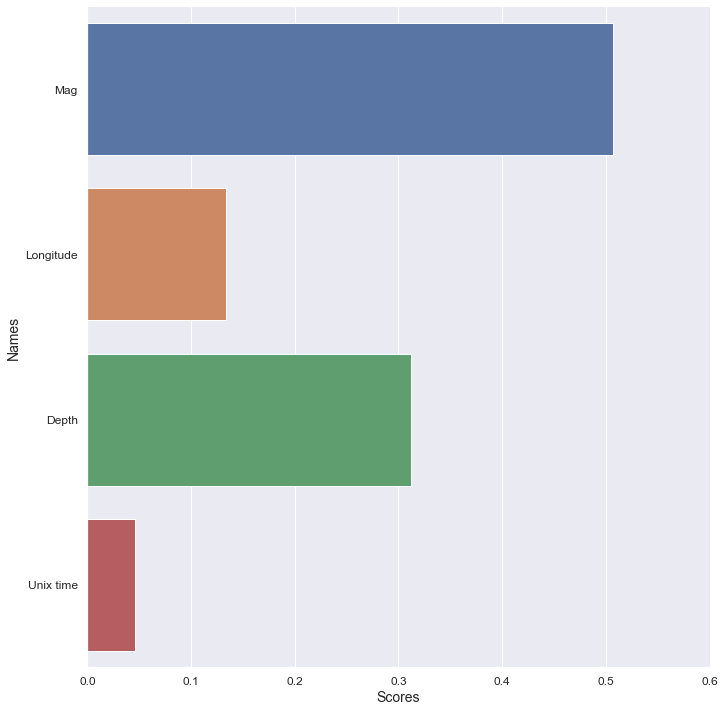

In [58]:
#visualize gini importance
features_lst = []
gini_score_lst = []
for feature, score in zip(cleaned_df_dropped[['mag', 'longitude', 'depth', 'Unix Time']],best_model.feature_importances_):
    features_lst.append(feature)
    gini_score_lst.append(score)
feature_lst = [feature.capitalize() for feature in features_lst]
d = {'Names': feature_lst, 'Scores': gini_score_lst}
gini_df = pd.DataFrame(d)

sns.set()

p = sns.catplot(y='Names', x="Scores", data=gini_df, kind='bar', height=10, aspect=1, legend=False)
p.set_ylabels(fontsize=14)
p.set_yticklabels(fontsize=12)
p.set_xticklabels(fontsize=12)
p.set_xlabels(fontsize=14)
plt.show()

Cross-Validation

In [59]:
#define number of splits for cross-validation
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 3868  3869  3870 ... 38671 38672 38673] | test: [   0    1    2 ... 3865 3866 3867]
Train: [    0     1     2 ... 38671 38672 38673] | test: [3868 3869 3870 ... 7733 7734 7735]
Train: [    0     1     2 ... 38671 38672 38673] | test: [ 7736  7737  7738 ... 11601 11602 11603]
Train: [    0     1     2 ... 38671 38672 38673] | test: [11604 11605 11606 ... 15469 15470 15471]
Train: [    0     1     2 ... 38671 38672 38673] | test: [15472 15473 15474 ... 19336 19337 19338]
Train: [    0     1     2 ... 38671 38672 38673] | test: [19339 19340 19341 ... 23203 23204 23205]
Train: [    0     1     2 ... 38671 38672 38673] | test: [23206 23207 23208 ... 27070 27071 27072]
Train: [    0     1     2 ... 38671 38672 38673] | test: [27073 27074 27075 ... 30937 30938 30939]
Train: [    0     1     2 ... 38671 38672 38673] | test: [30940 30941 30942 ... 34804 34805 34806]
Train: [    0     1     2 ... 34804 34805 34806] | test: [34807 34808 34809 ... 38671 38672 38673]


In [60]:
#calculate cross-validation score
from numpy import mean
from numpy import std

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), scoring='neg_mean_absolute_error', cv=k_fold, n_jobs=-1)
    print(cv_score)

# report performance
print('MAE: %.3f (%.3f)' % (mean(cv_score), std(cv_score)))

[-2.08728909 -2.53625438 -1.70792172 -2.83371055 -1.49703985 -2.48007782
 -2.17450695 -1.90426882 -2.23535881 -2.10435031]
MAE: -2.156 (0.377)


In [61]:
#define tree for plot validation curve
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [62]:
#create elements for plot validation curve
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

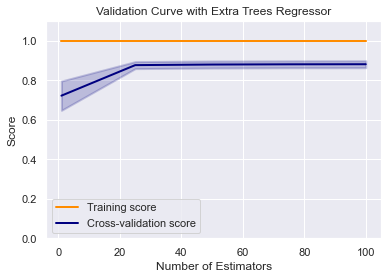

In [63]:
#plot validation curve
plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [64]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_lat = y_test
lats = actual_lat['latitude'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(lats, testpredict)
test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 6.672
MAE: 1.970


In [65]:
#make dataframe with actual test values and ML predicted ones
lat_pred = actual_lat
lat_pred['Predicted'] = testpredict


In [66]:
lat_pred = lat_pred.rename(columns={'latitude': 'Actual'})

In [67]:
lat_pred.head(5)

,Actual,Predicted
31109,56.351600,56.285791
27837,38.771333,38.770084
5591,54.649600,56.192958
21969,-6.497700,-3.849026
35589,34.229167,37.070842


In [68]:
#join dataframes for actual and predicted with original dataframe
lat_pred_all = lat_pred.merge(model_df, how='inner', left_index=True, right_index=True)
lat_pred_all.head(5)

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,Unix Time
31109,56.351600,56.285791,2022-03-25 16:00:55.679000+00:00,56.351600,-148.781200,10.00,3.30,ml,NaN,251.0,...,"254 km SE of Chiniak, Alaska",earthquake,10.80,2.00,0.057,40.0,reviewed,us,us,1.648224e+09
27837,38.771333,38.770084,2022-02-19 14:10:13.970000+00:00,38.771333,-122.710167,1.84,1.58,md,26.0,72.0,...,"2km WSW of Anderson Springs, CA",earthquake,0.25,0.22,0.002,2.0,reviewed,nc,nc,1.645280e+09
5591,54.649600,56.192958,2021-12-16 17:25:21.244000+00:00,54.649600,-163.397900,25.40,1.60,ml,NaN,NaN,...,"Unimak Island region, Alaska",earthquake,NaN,1.40,NaN,NaN,reviewed,ak,ak,1.639676e+09
21969,-6.497700,-3.849026,2022-02-10 13:20:40.227000+00:00,-6.497700,129.931000,150.46,4.60,mb,NaN,41.0,...,Banda Sea,earthquake,8.60,8.60,0.110,25.0,reviewed,us,us,1.644499e+09
35589,34.229167,37.070842,2022-03-11 15:03:17.330000+00:00,34.229167,-80.543000,1.19,2.09,md,10.0,87.0,...,"6 km ESE of Camden, South Carolina",earthquake,0.63,3.18,0.014,5.0,reviewed,se,se,1.647011e+09


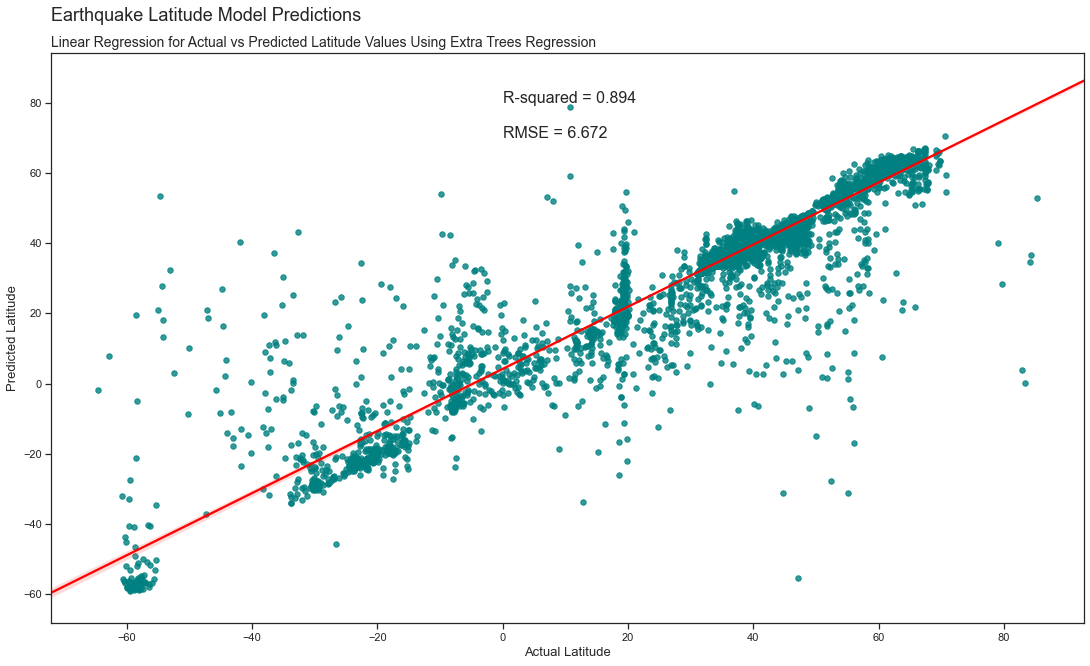

In [69]:
#plot actual vs predicted values
x = np.array(lat_pred_all['latitude'])
y = np.array(testpredict)


sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Latitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(lat_pred_all['latitude'], testpredict)), (0, 80),  fontsize=16)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 70), fontsize=16)

fig.savefig('../static/images/extratrees_lat_linear_sns.png', bbox_inches='tight',dpi=600)
plt.show()

In [70]:
# make a single prediction
from datetime import datetime
mag = float(input('Enter a magnitude: '))
lon = float(input('Enter a longitude (in decimal form; negative for west of meridian): '))
depth = float(input('Enter a depth (in km, only numerical value): '))
date_input = input('Enter a date (yyyy/mm/dd): ')
time_input = input('Enter a time in UTC (HH:MM:SS): ')
datetime_str = date_input + ' '+ time_input
date_time_obj = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
date_time_unix = (time.mktime(date_time_obj.timetuple()))
single_features = [[mag,lon,depth,date_time_unix]]
y_pred = best_model.predict(single_features)
print('Predicted Latitude: %g' % y_pred)

Predicted Latitude: 23.6109


Test with new data from USGS


In [71]:
#obtain USGS data for the day
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-03-31T23:28:24.250Z,38.825500,-122.761330,1.740000,0.70,md,11.0,134.0,0.008342,0.01,...,2022-03-31T23:30:02.567Z,"3km W of Cobb, CA",earthquake,0.36,0.66,0.160,2.0,automatic,nc,nc
1,2022-03-31T23:18:17.193Z,-4.899500,139.430100,10.000000,5.10,mb,NaN,64.0,7.429000,0.86,...,2022-03-31T23:30:45.040Z,"246 km WNW of Kiunga, Papua New Guinea",earthquake,8.00,1.90,0.076,57.0,reviewed,us,us
2,2022-03-31T23:17:48.900Z,19.245667,-155.399170,32.040001,2.13,ml,43.0,133.0,NaN,0.12,...,2022-03-31T23:23:18.190Z,"9 km ENE of Pāhala, Hawaii",earthquake,0.58,0.64,4.350,3.0,automatic,hv,hv
3,2022-03-31T23:09:00.430Z,33.902000,-117.747498,11.500000,1.32,ml,13.0,108.0,0.103800,0.37,...,2022-03-31T23:12:54.984Z,"6km ENE of Yorba Linda, CA",earthquake,1.19,2.91,0.319,15.0,automatic,ci,ci
4,2022-03-31T23:01:33.854Z,64.888200,-147.264900,21.400000,1.10,ml,NaN,NaN,NaN,1.01,...,2022-03-31T23:10:58.000Z,"10 km W of Two Rivers, Alaska",earthquake,NaN,0.50,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2022-03-30T23:40:45.084Z,62.621400,-150.179500,67.100000,1.40,ml,NaN,NaN,NaN,0.74,...,2022-03-30T23:45:35.852Z,"19 km NNW of Chase, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
262,2022-03-30T23:40:35.894Z,26.840500,126.413300,10.000000,4.20,mb,NaN,74.0,1.661000,1.10,...,2022-03-31T06:27:45.584Z,"Ryukyu Islands, Japan",earthquake,7.30,1.90,0.176,9.0,reviewed,us,us
263,2022-03-30T23:34:32.680Z,38.789001,-122.766167,2.520000,0.36,md,7.0,91.0,0.012660,0.02,...,2022-03-31T00:13:13.262Z,"2km NNW of The Geysers, CA",earthquake,0.52,1.82,NaN,1.0,automatic,nc,nc
264,2022-03-30T23:34:23.840Z,34.020333,-117.217833,16.640000,1.10,ml,45.0,48.0,0.088850,0.16,...,2022-03-31T14:57:32.302Z,"5km SE of Loma Linda, CA",earthquake,0.18,0.46,0.130,26.0,reviewed,ci,ci


In [72]:
#create unix time column and drop columns not needed

test_df['Unix Time'] = pd.to_datetime(test_df['time']).astype(int)/10**9
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df


,latitude,longitude,depth,mag,Unix Time
0,38.825500,-122.761330,1.740000,0.70,1.648769e+09
1,-4.899500,139.430100,10.000000,5.10,1.648769e+09
2,19.245667,-155.399170,32.040001,2.13,1.648769e+09
3,33.902000,-117.747498,11.500000,1.32,1.648768e+09
4,64.888200,-147.264900,21.400000,1.10,1.648768e+09
...,...,...,...,...,...
261,62.621400,-150.179500,67.100000,1.40,1.648684e+09
262,26.840500,126.413300,10.000000,4.20,1.648684e+09
263,38.789001,-122.766167,2.520000,0.36,1.648683e+09
264,34.020333,-117.217833,16.640000,1.10,1.648683e+09


In [73]:

#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
Unix Time    0
dtype: int64

In [74]:

#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['latitude'], axis = 1)

y_test_data = cleaned_test_df[['latitude']]


In [75]:
#predict values with best model
pred_data_y = best_model.predict(X_test_data)


In [76]:
#create dataframe with values
test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Unix Time,Predicted
0,38.825500,-122.761330,1.740000,0.70,1.648769e+09,38.812051
1,-4.899500,139.430100,10.000000,5.10,1.648769e+09,18.421893
2,19.245667,-155.399170,32.040001,2.13,1.648769e+09,19.223594
3,33.902000,-117.747498,11.500000,1.32,1.648768e+09,37.258517
4,64.888200,-147.264900,21.400000,1.10,1.648768e+09,62.933472
...,...,...,...,...,...,...
261,62.621400,-150.179500,67.100000,1.40,1.648684e+09,62.524270
262,26.840500,126.413300,10.000000,4.20,1.648684e+09,23.152481
263,38.789001,-122.766167,2.520000,0.36,1.648683e+09,38.789001
264,34.020333,-117.217833,16.640000,1.10,1.648683e+09,34.001522


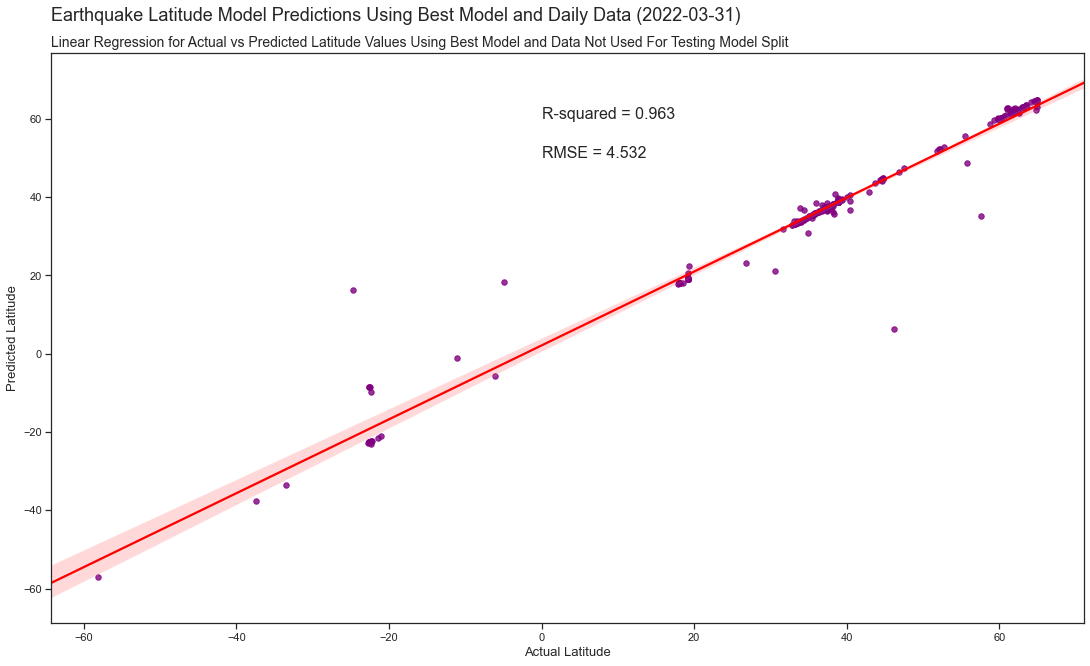

In [77]:
#create graph for actual vs predicted values
from datetime import date
today = date.today()
x = np.array(test_pred_data['latitude'])
y = np.array(pred_data_y)
test_mse = mean_squared_error(x, y)
rmse = sqrt(test_mse)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Latitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 60),  fontsize=16)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 50), fontsize=16)

fig.savefig('../static/images/extratrees_lat_linear_sns_daily.png', bbox_inches='tight', dpi=600)
plt.show()

In [78]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")

Connected to database...


In [79]:
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
lat_pred_all.to_sql('earthquake_etrees_lat', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
lat_pred_all.to_sql('earthquake_etrees_lat', conn, if_exists='replace', index=False)

12763

In [80]:
# Close connection to SQLite database
conn.close()
connection.close()